<a href="https://colab.research.google.com/github/divyansh-pathak129/AquaSentinel/blob/main/HackMIT%20Model%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
# import rasterio
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from PIL import Image
import cv2

In [ ]:
#  get datasets
"""
 feature enginereeing
 1) Slope
 2) Distance to Rivers/Water Bodies
 3) Curvature:
 4) Flow Accumulation/ physics thingy
 5)
"""


In [ ]:
# # Load a GeoTIFF depth map and returns a NumPy array
# def loaddata(path):
#       with rasterio.open(path) as src:
#       data = src.read(1)
#       return data




f = np.array([1, 2, 4, 7, 11, 16])
print(np.gradient(f))
print(np.gradient(f, 2,))
i = 000
i


[1.  1.5 2.5 3.5 4.5 5. ]
[0.5  0.75 1.25 1.75 2.25 2.5 ]


0

In [ ]:
def loadimg(filepath):
    """Loads a PNG image using OpenCV and returns it as a NumPy array."""
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    return img

def load_png(filepath):
    img = Image.open(filepath)
    return np.array(img)

def loadimgopencv(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED) # better for the terrain acc to internet
    return img

# for i= 0000
height_map_path = "/content/0001_h.png"
segmentation_map_path = "/content/0001_i2.png"
terrain_map_path = "/content/0001_t.png"

height_data = loadimg(height_map_path)
segmentation_data = loadimg(segmentation_map_path)
terrain_data = loadimgopencv(terrain_map_path) #opencv is better for terrain images.

segmentation_map = load_png(segmentation_map_path)
height_map = load_png(height_map_path)
terrain_map = load_png(terrain_map_path)

if height_data is not None:
    print("Height map loaded successfully.")
    print("Height map shape:", height_data.shape)
    # print(height_data)

if segmentation_data is not None:
    print("Segmentation map loaded successfully.")
    print("Segmentation map shape:", segmentation_data.shape)
    # print(segmentation_data)

if terrain_data is not None:
    print("Terrain map loaded successfully.")
    print("Terrain map shape:", terrain_data.shape)
    # print(terrain_data)


# resolution = idk

Height map loaded successfully.
Height map shape: (512, 512)
Segmentation map loaded successfully.
Segmentation map shape: (512, 512, 3)
Terrain map loaded successfully.
Terrain map shape: (512, 512, 3)


In [ ]:
def calculate_slope(height_data, resolution):

    dy, dx = np.gradient(height_data, resolution, resolution)

    slope = np.arctan(np.sqrt(dx**2 + dy**2))
    return slope

if height_data is not None:
    resolution = 400.0
    slope = calculate_slope(height_data, resolution)
    print("Slope calculated.")
    print("Slope shape:", slope.shape)
    # print(slope)

Slope calculated.
Slope shape: (512, 512)


In [ ]:
def extract_segmentation_labels(segmentation_data, color_map):
    numerical_labels = np.zeros(segmentation_data.shape[:2], dtype=np.uint8)
    for label, color in color_map.items():
        mask = np.all(segmentation_data == color, axis=-1)
        numerical_labels[mask] = label
    return numerical_labels



color_map = {
    1: (17, 141, 215),  # Water
    2: (225, 227, 155),  # Grassland
    3: (127, 173, 123),  # Forest
    4: (185, 122, 87),   # Hills
    5: (230, 200, 181),  # Desert
    6: (150, 150, 150),  # Mountain
    7: (193, 190, 175)   # Tundra
}


numerical_segmentation = extract_segmentation_labels(segmentation_map, color_map)


print("Height map shape:", height_map.shape)
print("Segmentation map shape:", segmentation_map.shape)
print("Terrain map shape:", terrain_map.shape)
print("Slope shape:", slope.shape)
print("Numerical segmentation shape:", numerical_segmentation.shape)

print("Example slope value:", slope[100, 100])
print("Example segmentation label:", numerical_segmentation[256, 256])

Height map shape: (512, 512)
Segmentation map shape: (512, 512, 3)
Terrain map shape: (512, 512, 3)
Slope shape: (512, 512)
Numerical segmentation shape: (512, 512)
Example slope value: 0.0
Example segmentation label: 3


In [ ]:

def flood_simulation(height_map, water_rise_amount=10, flow_weight=0.5):


    height_map_copy = height_map.copy().astype(np.float32)
    lowest_point = np.min(height_map_copy)
    flood_map = np.zeros_like(height_map_copy, dtype=np.uint8)
    water_level = lowest_point
    change_count = 0

    while water_level < np.max(height_map_copy):
        flooded_areas = height_map_copy <= water_level
        new_flood_map = flood_map.copy()

        new_flood_map[flooded_areas] = 255


        for i in range(1, flood_map.shape[0] - 1):# 1 , flood_map.shape[0] - 1 is because my file is bigger than it needs to be  so im skipping those clo and rows
            for j in range(1, flood_map.shape[1] - 1):
                if new_flood_map[i, j] == 0:
                    neighbors = [
                        (i - 1, j, height_map_copy[i - 1, j]),# (i,j,h)
                        (i + 1, j, height_map_copy[i + 1, j]),
                        (i, j - 1, height_map_copy[i, j - 1]),
                        (i, j + 1, height_map_copy[i, j + 1]),
                    ]
                    for i, j, h in neighbors:# calculates the flood rate acc slope
                        if new_flood_map[i, j] == 255:
                            height_diff = height_map_copy[i, j] - h
                            if height_diff <= 0:# if its below or at the same level itll flow
                                flow_probability = 1.0
                                if height_diff > 0:
                                    flow_probability = flow_weight * (1.0 - (height_diff / water_rise_amount)) # idk y it works but it works
                                # if np.random.rand() < flow_probability: # random variable flow rate real-life like ???????
                                #     new_flood_map[i, j] = 255
                                #     break
        if np.array_equal(flood_map, new_flood_map): #Iteration control.
            change_count+=1
            if change_count > 3:
                break;
        else:
            change_count = 0;
        flood_map = new_flood_map
        water_level = water_level + water_rise_amount


    return flood_map



In [ ]:
def visualize_flood_map(flood_map):
    plt.imshow(height_map, cmap='terrain')  # Display heightmap
    plt.imshow(flood_map, cmap='Reds', alpha=0.5)  # Overlay flood map
    plt.title("Flood Overlay")
    plt.show()

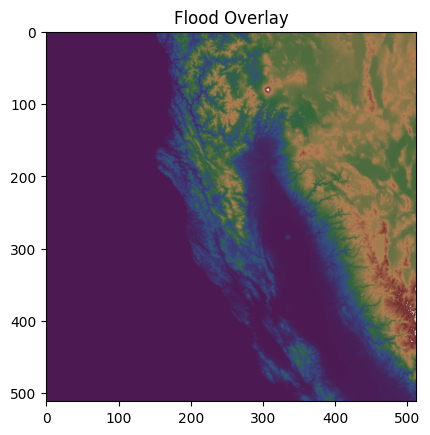

In [ ]:
visualize_flood_map(flood_map)


In [ ]:
flood_map = flood_simulation(height_map)

In [ ]:
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(flood_labels.shape[1] * flood_labels.shape[2], activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape)
    model.summary()

    return model


In [ ]:
model = build_cnn_model()

TypeError: build_cnn_model() missing 1 required positional argument: 'input_shape'

In [ ]:
model.fit(
    X_train,
    y_train.reshape(y_train.shape[0], output_size),
    epochs=10,
    validation_split=0.1
)
loss, accuracy = model.evaluate(
    X_test,
    y_test.reshape(y_test.shape[0], output_size)
)